# 📖 딥러닝 모델의 Inductive Bias & NSMC 감정 분석 실습

## ✅ **TODO: 과제 1 - Inductive Bias 탐구**
- [ ] FC Layer, RNN, LSTM, Attention의 Inductive Bias 조사  
- [ ] 개인의 해석을 정리하여 기입

---

## ✅ **TODO: 과제 2 - NSMC 감정 분석 실습** (❗빈칸 채우기 실습 포함 )  
- [ ] NSMC 데이터 전처리 (토큰화, 어휘 사전 생성)  
- [ ] RNN, LSTM, Attention 모델 구현 **(빈칸 채우기!)**  
- [ ] 모델 학습 및 평가 (정확도 비교, Confusion Matrix 분석)  
- [ ] 사용자 입력 문장 감정 분석  

📌 **Colab 실행 시 GPU (`T4`) 사용 권장!**


---
---

# 📖 과제 1 : FC Layer, RNN, LSTM, Attention의 Inductive Bias 탐구

## 📌 과제 개요  
이 과제에서는 딥러닝에서 자주 사용되는 **Fully Connected (FC) Layer, RNN, LSTM, Attention**의 **Inductive Bias**를 비교·탐구합니다.  
Inductive Bias란 **모델이 학습할 때 선호하는 패턴이나 추론 방식의 특성을 의미**하며, 서로 다른 신경망 구조에서 어떻게 다르게 나타나는지 분석하는 것이 목표입니다.  



## 📂  과제 요구사항  

### 📌 모델별 Inductive Bias 개념 조사  
각 모델이 가지고 있는 **Inductive Bias**에 대해 조사하고, **이론적 배경을 정리**하세요.  
다음 질문에 대한 답변을 정리하세요.


**FC Layer**: Fully Connected Layer는 어떤 inductive bias를 가지며, 어떤 패턴을 학습하는가?  

답변 : 모든 입력 element가 출력 element에 연결되어 있기에 영향을 주어 inductive bias가 없다.

**RNN**: 순환 구조가 inductive bias에 어떤 영향을 미치는가?  

답변 : 순환 구조를 가지고 있다는 점에서 입력이 시계열의 특징을 가지고 있을 것이라고 가정하고, 또한 순환 구조를 띄고 있기 때문에 동일한 순서로 입력이 들어올 시 출력도 동일하다.

**LSTM**: 장기 의존성 문제를 해결하기 위해 어떤 inductive bias가 추가되는가?  
답변 : 셀 상태와 게이트 메커니즘이라는 inductive bias가 추가된다.

**Attention**: 문장 내 특정 단어에 집중하는 Attention 메커니즘의 inductive bias는 어떤 특징이 있는가?

답변 : 모든 단어에 집중하는 것이 아니라, 다양한 element 중 특정한 요소에 집중한다는 bias를 가졌다고 생각한다. 즉 모든 요소가 중요한 경우가 존재할 수 있음에도 불구하고, 어떠한 요소를 자연스럽게 소홀히 볼 수 밖에 없다는 편향이 존재하는 것 같다.

---

# 📖 과제 2 : 네이버 영화 리뷰 감정 분석 (NSMC) 실습  

## 📌 1. 실습 개요  
이 실습에서는 **네이버 영화 리뷰 감정 분석 데이터(NSMC)**를 사용하여 텍스트 감정을 분류하는 **딥러닝 모델(RNN, LSTM, RNN+Attention)**을 학습합니다.  
각 모델의 성능을 비교하고, **사용자 입력 문장에 대한 감정 예측**을 수행합니다.  


## 🎯 2. 실습 목표  
✔ 감정 분석을 위한 데이터 전처리 및 모델 학습 이해  
✔ RNN, LSTM, Attention을 활용한 감정 분석 모델 구현 및 성능 비교  
✔ 학습한 모델이 실제 문장을 어떻게 분류하는지 확인  

### GPU 사용 권장! (ex, colab의 T4)


In [2]:
############################
# 0. 기본 설치 (Colab 환경)
############################

# Colab 등에서 한국어 형태소 분석기 사용 위해 konlpy 설치

!pip install konlpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 36.7 MB/s eta 0:00:00


In [3]:
############################
# 1. 라이브러리 임포트
############################

import sys
import os
import urllib.request

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader

# GPU 사용 가능 여부
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 한국어 형태소 분석기 (예: Okt 사용)
from konlpy.tag import Okt
okt = Okt()


Using device: cuda


In [4]:
############################
# 2. NSMC 데이터 다운로드
############################

# ratings_train.txt, ratings_test.txt 파일이 없다면 다운로드
# (Colab 환경에서 예시)
if not os.path.isfile("ratings_train.txt"):
    url_train = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
    urllib.request.urlretrieve(url_train, "ratings_train.txt")

if not os.path.isfile("ratings_test.txt"):
    url_test = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"
    urllib.request.urlretrieve(url_test, "ratings_test.txt")

print("NSMC 데이터 다운로드 완료")


NSMC 데이터 다운로드 완료


In [5]:
############################
# 3. 데이터 로드 및 전처리
############################

def load_data(filepath):
    """
    ratings_train.txt / ratings_test.txt 파일을 불러와서
    [text, label] 형태의 리스트를 반환
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        next(f)  # 헤더 건너뛰기
        for line in f:
            id_, text, label = line.strip().split('\t')
            if text == "":  # 공백 리뷰 제거
                continue
            data.append((text, int(label)))
    return data

train_data_raw = load_data("ratings_train.txt")
test_data_raw = load_data("ratings_test.txt")

print("훈련 데이터 개수:", len(train_data_raw))
print("테스트 데이터 개수:", len(test_data_raw))

# 데이터 샘플 확인
print("\n첫 번째 훈련 샘플:", train_data_raw[0])


훈련 데이터 개수: 149995
테스트 데이터 개수: 49997

첫 번째 훈련 샘플: ('아 더빙.. 진짜 짜증나네요 목소리', 0)


In [6]:
############################
# 3-1. 형태소 분석 & 토큰화
############################

def tokenize(text):
    """
    간단히 Okt 형태소 분석기로 명사, 동사 등 단어 단위 토큰화 예시.
    필요에 따라 불용어 제거 등의 추가 처리가 가능.
    """
    # 예시: 불필요한 기호 제거 (정규 표현식 등)
    # 여기서는 간단히 한글, 영문, 숫자, 공백, 일부 문장부호만 남긴다고 가정
    import re
    text = re.sub(r"[^가-힣0-9a-zA-Z\s?!.,]", "", text)

    # 형태소 분석(Okt)
    # 이 예시에선 그냥 morphemes만 추출
    tokens = okt.morphs(text.strip())
    return tokens

# 간단 테스트
sample_text = train_data_raw[0][0]
print("원문:", sample_text)
print("토큰화 결과:", tokenize(sample_text))


원문: 아 더빙.. 진짜 짜증나네요 목소리
토큰화 결과: ['아', '더빙', '..', '진짜', '짜증나네요', '목소리']


In [7]:
############################
# 3-2. 어휘 사전(Vocabulary) 생성
############################

from collections import defaultdict

# 매우 큰 데이터를 모두 사용할 경우 시간이 오래 걸릴 수 있으므로,
# 우선 "일부" 데이터(예: 상위 N개)만 사용해 시범실습할 수도 있습니다.
# 필요시 full_data = train_data_raw 로 변경하세요.
N = 20000  # 시범으로 2만 개만 사용할 경우
full_data = train_data_raw[:N]

word_freq = defaultdict(int)

for text, label in full_data:
    tokens = tokenize(text)
    for tok in tokens:
        word_freq[tok] += 1

# 사용 빈도가 낮은 단어는 제외 (예: 3회 미만)
min_freq = 3
vocab = ["<pad>", "<unk>"]
for w, f in word_freq.items():
    if f >= min_freq:
        vocab.append(w)

word2idx = {w: i for i, w in enumerate(vocab)}
print("단어 사전 크기:", len(vocab))

def text_to_ids(text, word2idx):
    tokens = tokenize(text)
    ids = []
    for tok in tokens:
        ids.append(word2idx.get(tok, word2idx["<unk>"]))
    return ids


단어 사전 크기: 8845


In [8]:
############################
# 4. Dataset 및 DataLoader 구성
############################

# 최대 문장 길이(패딩을 위한). 너무 크게 잡으면 메모리 사용량 증가
max_len = 30

def pad_sequences(seq, max_len):
    """
    입력된 seq (List of token ids)에 대해
    max_len만큼 뒤를 <pad> 토큰으로 채워넣거나 자르는 함수
    """
    if len(seq) < max_len:
        seq = seq + [word2idx["<pad>"]] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

class NSMCDataset(Dataset):
    def __init__(self, data, word2idx, max_len=30):
        self.data = data
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        token_ids = text_to_ids(text, self.word2idx)
        token_ids = pad_sequences(token_ids, self.max_len)
        return torch.LongTensor(token_ids), torch.LongTensor([label])

# 실제로는 전 데이터 쓰려면 full_data = train_data_raw, etc.
# 여기서는 위에서 N=20000으로 제한한 데이터 사용 (시간 단축용)
train_dataset = NSMCDataset(full_data, word2idx, max_len=max_len)
test_dataset = NSMCDataset(test_data_raw, word2idx, max_len=max_len)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"훈련 배치 개수: {len(train_loader)}")
print(f"테스트 배치 개수: {len(test_loader)}")


훈련 배치 개수: 313
테스트 배치 개수: 782


In [9]:
############################
# 4. Dataset 및 DataLoader 구성
############################

# 최대 문장 길이(패딩을 위한). 너무 크게 잡으면 메모리 사용량 증가
max_len = 30

def pad_sequences(seq, max_len):
    """
    입력된 seq (List of token ids)에 대해
    max_len만큼 뒤를 <pad> 토큰으로 채워넣거나 자르는 함수
    """
    if len(seq) < max_len:
        seq = seq + [word2idx["<pad>"]] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

class NSMCDataset(Dataset):
    def __init__(self, data, word2idx, max_len=30):
        self.data = data
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        token_ids = text_to_ids(text, self.word2idx)
        token_ids = pad_sequences(token_ids, self.max_len)
        return torch.LongTensor(token_ids), torch.LongTensor([label])

# 실제로는 전 데이터 쓰려면 full_data = train_data_raw, etc.
# 여기서는 위에서 N=20000으로 제한한 데이터 사용 (시간 단축용)
train_dataset = NSMCDataset(full_data, word2idx, max_len=max_len)
test_dataset = NSMCDataset(test_data_raw, word2idx, max_len=max_len)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"훈련 배치 개수: {len(train_loader)}")
print(f"테스트 배치 개수: {len(test_loader)}")


훈련 배치 개수: 313
테스트 배치 개수: 782


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

############################
# 5. 모델 정의
#   5-1) RNN Classifier
############################

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=2):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)  # 입력 차원은 단어 임베딩 차원, 은닉 상태 차원은 hidden_dim
        self.fc = nn.Linear(hidden_dim, num_classes)  # 마지막 은닉 상태 크기와 출력 클래스 개수

    def forward(self, x):
        # x shape: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        output, hidden = self.rnn(embedded)  # RNN 입력은 임베딩된 단어 벡터
        last_hidden = hidden[0]  # RNN의 마지막 은닉 상태를 가져오기 (0번째 인덱스 사용)
        logits = self.fc(last_hidden)  # 최종 은닉 상태를 FC Layer에 통과시켜 감정 예측
        return logits

############################
#   5-2) LSTM Classifier
############################

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=2):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # 단어 사전 크기와 임베딩 차원 입력
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)  # LSTM의 입력 차원은 embed_dim, 출력 차원은 hidden_dim
        self.fc = nn.Linear(hidden_dim, num_classes)  # 마지막 은닉 상태 크기와 출력 클래스 개수

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[0]  # LSTM의 마지막 hidden state 사용, 0번째 인덱스
        logits = self.fc(last_hidden)  # 마지막 은닉 상태를 FC Layer에 통과시켜 감정 예측
        return logits

############################
#   5-3) RNN + Attention
############################

class RNNWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=2):
        super(RNNWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # 단어 사전 크기와 임베딩 차원 입력
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)  # RNN의 입력 차원은 embed_dim, 출력 차원은 hidden_dim
        self.attn_fc = nn.Linear(hidden_dim, hidden_dim)  # attention 가중치를 학습하는 FC Layer, 입력은 hidden_dim
        self.fc = nn.Linear(hidden_dim, num_classes)  # 최종 context 벡터를 감정 분류하는 FC Layer에 입력

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        output, hidden = self.rnn(embedded)  # (batch, seq_len, hidden_dim)

        # 스코어 계산
        score = torch.tanh(self.attn_fc(output))  # output을 attention layer에 통과

        # hidden_dim -> 1 로 축소하여 각 타임스텝별 스칼라 스코어 얻기
        score = torch.sum(score, dim=2)  # hidden_dim 차원 축소, dim=2

        # softmax로 가중치 계산
        attn_weights = F.softmax(score, dim=1).unsqueeze(-1)  # 시퀀스 차원에 대해 softmax 적용, dim=1

        # 가중합
        context = output * attn_weights  # (batch, seq_len, hidden_dim)
        context = torch.sum(context, dim=1)  # 타임스텝 차원을 축소하여 문장 단위 벡터 얻기, dim=1

        logits = self.fc(context)  # context 벡터를 FC Layer에 입력하여 감정 분류
        return logits

In [11]:
############################
# 6. 학습 / 평가 루프 정의
############################

def train_model(model, train_loader, val_loader=None, epochs=5, lr=0.001):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)      # (batch, seq_len)
            labels = labels.squeeze().to(device)  # (batch)

            optimizer.zero_grad()
            outputs = model(inputs)         # (batch, num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 에폭별 평균 로스
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # 검증 정확도(옵션)
        if val_loader is not None:
            acc = evaluate_model(model, val_loader)
            val_accuracies.append(acc)
            print(f"[Epoch {epoch}] Train Loss: {epoch_loss:.4f}, Val Acc: {acc*100:.2f}%")
        else:
            print(f"[Epoch {epoch}] Train Loss: {epoch_loss:.4f}")

    return train_losses, val_accuracies

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (inputs, labels) in data_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(all_labels, all_preds)
    return acc

def plot_training_curve(train_losses, val_accuracies=None, title="Training Curve"):
    plt.figure(figsize=(10,4))

    # 학습 손실 곡선
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 검증 정확도 곡선
    if val_accuracies is not None and len(val_accuracies) > 0:
        plt.subplot(1,2,2)
        plt.plot(val_accuracies, label='Val Acc', color='orange')
        plt.title("Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.suptitle(title)
    plt.show()


In [12]:
############################
# 7. 데이터 분할(Train/Valid) 준비
############################

# 여기서는 별도의 Validation 세트를 만들지 않고,
# 주어진 test_data_raw를 최종 테스트 용도로만 사용할 수도 있음.
# 하지만 간단히 train_data_raw를 다시 train/val로 나누는 방법 시연.

from sklearn.model_selection import train_test_split

# 현재 full_data (N=20000) 중 80%: train, 20%: val
train_subset, val_subset = train_test_split(full_data, test_size=0.2, random_state=42)

train_dataset_2 = NSMCDataset(train_subset, word2idx, max_len)
val_dataset_2   = NSMCDataset(val_subset, word2idx, max_len)

train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
val_loader_2   = DataLoader(val_dataset_2, batch_size=batch_size, shuffle=False)

print(f"Train subset: {len(train_subset)}, Val subset: {len(val_subset)}")


Train subset: 16000, Val subset: 4000


========= RNN Training =========
[Epoch 1] Train Loss: 0.6995, Val Acc: 51.23%
[Epoch 2] Train Loss: 0.6895, Val Acc: 51.08%
[Epoch 3] Train Loss: 0.6799, Val Acc: 48.65%
[Epoch 4] Train Loss: 0.6633, Val Acc: 48.27%
[Epoch 5] Train Loss: 0.6472, Val Acc: 51.25%


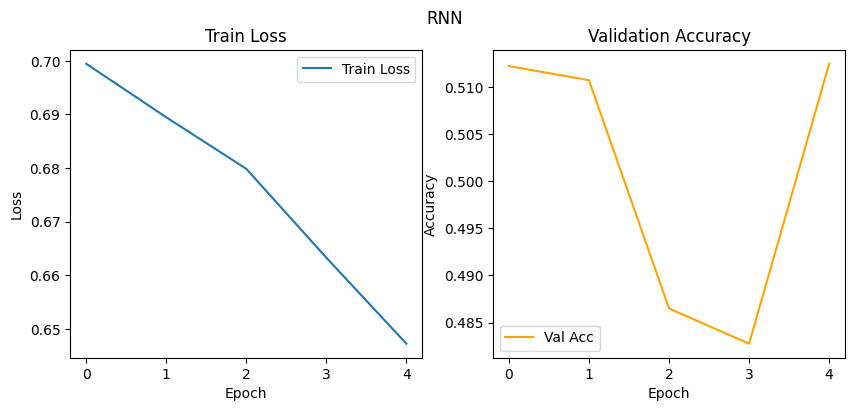

RNN Test Accuracy: 51.42%

========= LSTM Training =========
[Epoch 1] Train Loss: 0.6940, Val Acc: 49.53%
[Epoch 2] Train Loss: 0.6312, Val Acc: 73.20%
[Epoch 3] Train Loss: 0.4581, Val Acc: 77.25%
[Epoch 4] Train Loss: 0.3454, Val Acc: 78.30%
[Epoch 5] Train Loss: 0.2569, Val Acc: 79.05%


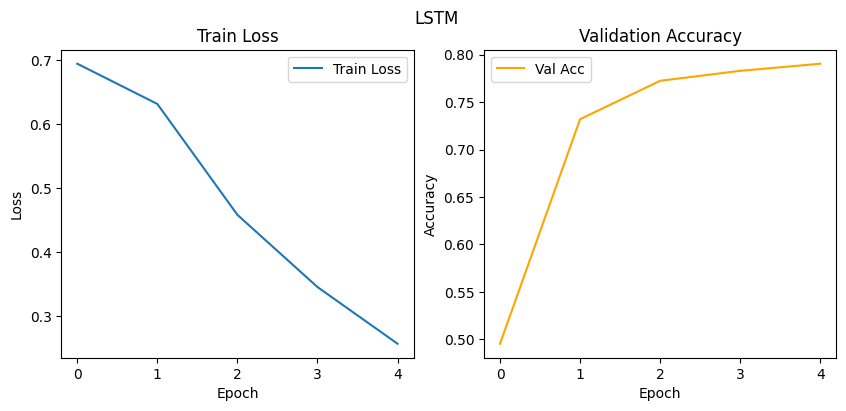

LSTM Test Accuracy: 78.70%

========= RNN + Attention Training =========
[Epoch 1] Train Loss: 0.6631, Val Acc: 62.52%
[Epoch 2] Train Loss: 0.6103, Val Acc: 67.42%
[Epoch 3] Train Loss: 0.5583, Val Acc: 70.62%
[Epoch 4] Train Loss: 0.5157, Val Acc: 71.25%
[Epoch 5] Train Loss: 0.4643, Val Acc: 71.67%


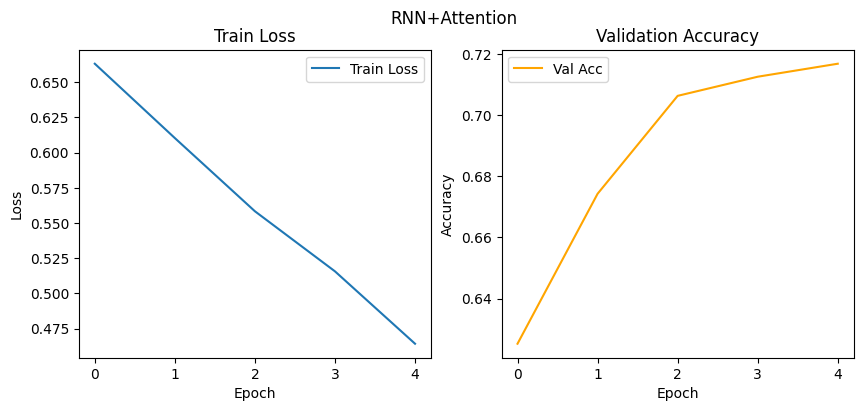

RNN+Attention Test Accuracy: 71.38%



In [14]:
############################
# 8. 모델별 학습 & 평가
############################

embed_dim = 128
hidden_dim = 128
num_classes = 2
EPOCHS = 5 # 유동적으로 조절하세요
LR = 0.001

# --- 8-1. RNN ---
print("========= RNN Training =========")
rnn_model = RNNClassifier(len(vocab), embed_dim, hidden_dim, num_classes)
rnn_train_losses, rnn_val_accs = train_model(rnn_model, train_loader_2, val_loader_2, epochs=EPOCHS, lr=LR)
plot_training_curve(rnn_train_losses, rnn_val_accs, title="RNN")

# 최종 테스트 세트 정확도
rnn_test_acc = evaluate_model(rnn_model, test_loader)
print(f"RNN Test Accuracy: {rnn_test_acc*100:.2f}%\n")

# --- 8-2. LSTM ---
print("========= LSTM Training =========")
lstm_model = LSTMClassifier(len(vocab), embed_dim, hidden_dim, num_classes)
lstm_train_losses, lstm_val_accs = train_model(lstm_model, train_loader_2, val_loader_2, epochs=EPOCHS, lr=LR)
plot_training_curve(lstm_train_losses, lstm_val_accs, title="LSTM")

# 최종 테스트 세트 정확도
lstm_test_acc = evaluate_model(lstm_model, test_loader)
print(f"LSTM Test Accuracy: {lstm_test_acc*100:.2f}%\n")

# --- 8-3. RNN + Attention ---
print("========= RNN + Attention Training =========")
attn_model = RNNWithAttention(len(vocab), embed_dim, hidden_dim, num_classes)
attn_train_losses, attn_val_accs = train_model(attn_model, train_loader_2, val_loader_2, epochs=EPOCHS, lr=LR)
plot_training_curve(attn_train_losses, attn_val_accs, title="RNN+Attention")

# 최종 테스트 세트 정확도
attn_test_acc = evaluate_model(attn_model, test_loader)
print(f"RNN+Attention Test Accuracy: {attn_test_acc*100:.2f}%\n")


=== Confusion Matrix: RNN ===


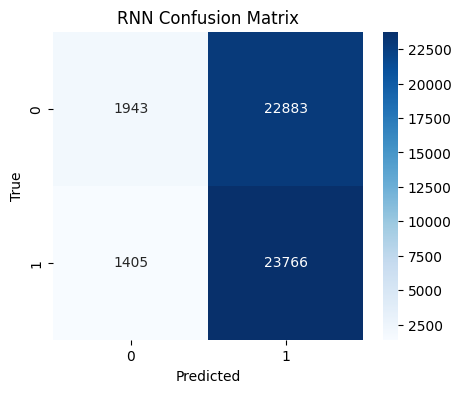

=== Confusion Matrix: LSTM ===


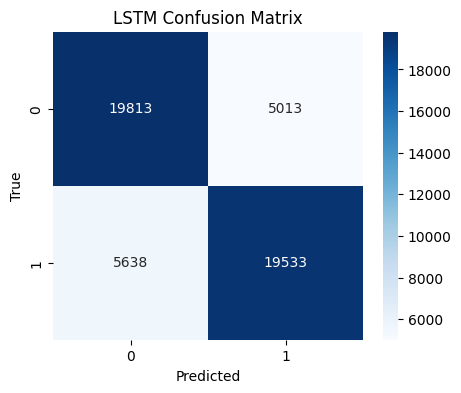

=== Confusion Matrix: RNN+Attention ===


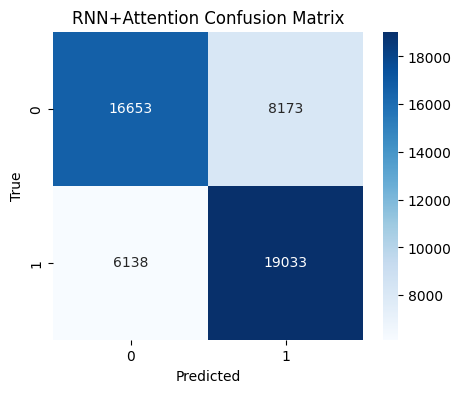

In [15]:
############################
# 9. 혼동 행렬(Confusion Matrix) 시각화
############################

def plot_confusion_matrix(model, data_loader, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (inputs, labels) in data_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("=== Confusion Matrix: RNN ===")
plot_confusion_matrix(rnn_model, test_loader, title="RNN Confusion Matrix")

print("=== Confusion Matrix: LSTM ===")
plot_confusion_matrix(lstm_model, test_loader, title="LSTM Confusion Matrix")

print("=== Confusion Matrix: RNN+Attention ===")
plot_confusion_matrix(attn_model, test_loader, title="RNN+Attention Confusion Matrix")


In [16]:
import torch
import torch.nn.functional as F

# 문장을 모델이 예측할 수 있도록 변환하고 감정 분석 수행
def predict_sentiment(model, sentence, word2idx, max_len=30):
    """
    감정 분석을 수행하는 함수 (입력 문장을 숫자 토큰으로 변환 후 모델에 입력)
    """
    model.eval()
    tokens = tokenize(sentence)  # 형태소 분석 및 토큰화
    token_ids = [word2idx.get(tok, word2idx["<unk>"]) for tok in tokens]  # 단어를 ID로 변환
    token_ids = pad_sequences(token_ids, max_len)  # 패딩 적용

    input_tensor = torch.LongTensor(token_ids).unsqueeze(0).to(device)  # (1, seq_len)

    with torch.no_grad():
        output = model(input_tensor)  # 모델 예측
        probs = F.softmax(output, dim=1)  # 확률 값
        pred_label = torch.argmax(probs, dim=1).item()  # 예측 라벨 (0: 부정, 1: 긍정)

    return pred_label, probs.squeeze().cpu().numpy()


In [19]:
# 예측 함수: 3개 모델 모두 실행
def predict_with_all_models(sentence):
    """
    사용자 입력 문장에 대해 RNN, LSTM, RNN+Attention 모델이 각각 어떻게 예측하는지 출력
    """
    print("\n💬 입력 문장:", sentence)
    print("=" * 50)

    models = {
        "RNN": rnn_model,
        "LSTM": lstm_model,
        "RNN+Attention": attn_model
    }

    for model_name, model in models.items():
        label, probs = predict_sentiment(model, sentence, word2idx)
        sentiment = "긍정 😊" if label == 1 else "부정 😡"

        print(f"🧠 [{model_name} 모델]")
        print(f"🔍 예측 감정: {sentiment}")
        print(f"📊 확률: 부정 {probs[0]:.4f} | 긍정 {probs[1]:.4f}")
        print("-" * 50)

# 사용자 입력 받기
sample_sentence = input("문장을 입력하세요: ")
predict_with_all_models(sample_sentence)


문장을 입력하세요: 다 때려쳐!

💬 입력 문장: 다 때려쳐!
🧠 [RNN 모델]
🔍 예측 감정: 긍정 😊
📊 확률: 부정 0.4479 | 긍정 0.5521
--------------------------------------------------
🧠 [LSTM 모델]
🔍 예측 감정: 긍정 😊
📊 확률: 부정 0.0939 | 긍정 0.9061
--------------------------------------------------
🧠 [RNN+Attention 모델]
🔍 예측 감정: 부정 😡
📊 확률: 부정 0.5838 | 긍정 0.4162
--------------------------------------------------
